In [1]:
!/usr/local/cuda/bin/nvcc —version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ & cd /root/NVIDIA_CUDA-11.2_samples/


nvcc fatal   : Don't know what to do with '—version'
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-wjj13vth
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-wjj13vth
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=951e0be159fd7e655bc7ff6b4481145ea5fcc1a8e880f6fc7f5ae33ab1e1e4a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ge70odl/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out
/bin/bash: line 1: cd: /root/NVIDIA_CUDA-11.2_samples/: No such file or directory
/bin/bash: line 1: cuda-install-samples-11.2.sh: command not found


In [4]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <malloc.h>
#include <stdio.h>
#include <stdlib.h>
#include <ctime>
#include <math.h>


//Kernel function on GPU
__global__ void addKernel(double* c, double* a, double* b, int size) {
    int ROW = blockIdx.y * blockDim.y + threadIdx.y;
    int COL = blockIdx.x * blockDim.x + threadIdx.x;
    double tmp_sum = 0;
    if (ROW < size && COL < size) {
        tmp_sum = 0;
        for (int i = 0; i < size; i++) {
            tmp_sum += a[ROW * size + i] * b[i * size + COL];
        }
    }
    c[ROW * size + COL] = tmp_sum;

}
//Print Matrix
void print_matrix(double* matrix, int rows, int cols) {
    for (int i = 0; i < rows; ++i) {
        for (int j = 0; j < cols; ++j) {
            printf("%f ", matrix[j + i * rows]);
        }
        printf("\n");
    }
    printf("\n");
}


int main()
{
    for (int incDimension = 1; incDimension < 9; ++incDimension) {
        int n = 256*incDimension;
        //Задаём параметры грида
        dim3 dimBlock(32, 32);
        dim3 dimGrid;
        dimGrid.x = ceil(double(n) / double(dimBlock.x));
        dimGrid.y = ceil(double(n) / double(dimBlock.y));
        printf("\nGridDim := (%d,%d)", dimGrid.x, dimGrid.y);
        printf("\nBlockDim := (%d,%d)", dimBlock.x, dimBlock.y);
        //Вывод размерности матрицы
        printf("\nMatrix dimension := %dx%d\n", n, n);
        int n2b = n * n * sizeof(double);
        int n2 = n;

        // Выделение памяти на хосте
        double* A = new double[n * n];
        double* B = new double[n * n];
        double* C = new double[n * n];
        double sum = 0;

        // Инициализация массивов
        for (int i = 0; i < n * n; i++) {
            A[i] = sin(i);
            B[i] = cos(i);
        }
        printf("\nMatrix A :=\n");
        print_matrix(A, 2, 2);
        printf("\nMatrix B :=\n");
        print_matrix(B, 2, 2);
        //MatMul on CPU
        clock_t st_time = clock();
        for (int row = 0; row < n; row++) {
            for (int col = 0; col < n; col++) {
                sum = 0;
                for (int k = 0; k < n; k++) {
                    sum += A[row * n + k] * B[k * n + col];
                }
                C[row * n + col] = sum;
            }
        }
        printf("\n");
        clock_t end_time = clock();
        float CPU_time = ((double)end_time - st_time) / ((double)CLOCKS_PER_SEC);
        printf("\nThe CPU calculated for %.7f second(s)\n", CPU_time);
        // Выделение памяти на устройстве
        double* Adev = NULL;
        cudaError_t cuerr = cudaMalloc((void**)&Adev, n2b);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot allocate device array for a: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        double* Bdev = NULL;
        cuerr = cudaMalloc((void**)&Bdev, n2b);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot allocate device array for b: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        double* Cdev = NULL;
        cuerr = cudaMalloc((void**)&Cdev, n2b);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot allocate device array for c: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        // Создание обработчиков событий
        cudaEvent_t start, stop;
        float gpuTime = 0.0;
        cuerr = cudaEventCreate(&start);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot create CUDA start event: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        cuerr = cudaEventCreate(&stop);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot create CUDA end event: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        // Копирование данных с хоста на девайс
        cuerr = cudaMemcpy(Adev, A, n2b, cudaMemcpyHostToDevice);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot copy a array from host to device: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        cuerr = cudaMemcpy(Bdev, B, n2b, cudaMemcpyHostToDevice);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot copy b array from host to device: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        // Установка точки старта
        cuerr = cudaEventRecord(start, 0);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot record CUDA event: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        //Запуск ядра
        addKernel <<< dimGrid, dimBlock >>> (Cdev, Adev, Bdev, n);
        // Расчет времени


        cuerr = cudaGetLastError();
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot launch CUDA kernel: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        // Синхронизация устройств
        cuerr = cudaDeviceSynchronize();
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot synchronize CUDA kernel: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }
        //Количество нитей меньше количества элементов
        // Установка точки окончания
        cuerr = cudaEventRecord(stop, 0);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot copy c array from device to host: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }

        // Копирование результата на хост
        cuerr = cudaMemcpy(C, Cdev, n2b, cudaMemcpyDeviceToHost);
        if (cuerr != cudaSuccess)
        {
            fprintf(stderr, "Cannot copy c array from device to host: %s\n",
                cudaGetErrorString(cuerr));
            return 0;
        }
        cuerr = cudaEventElapsedTime(&gpuTime, start, stop);
        printf("The GPU calculated for %s: %.9f seconds\n", "kernel", gpuTime / 1000);
        printf("\nAcceleration on GPU := %.9f\n", CPU_time / (gpuTime / 1000));
        // Расчет времени

        // Очищение памяти
        printf("\nMatMul result after copying from host\n");
        printf("\nMatrix C := \n");
        print_matrix(C, 2, 2);

        cudaEventDestroy(start);
        cudaEventDestroy(stop);

        //Free GPU memory
        cudaFree(Adev);
        cudaFree(Bdev);
        cudaFree(Cdev);

        // Free CPU memory
        free(A);
        free(B);
        free(C);

    }
    return 0;
}


GridDim := (8,8)
BlockDim := (32,32)
Matrix dimension := 256x256

Matrix A :=
0.000000 0.841471 
0.909297 0.141120 


Matrix B :=
1.000000 0.540302 
-0.416147 -0.989992 



The CPU calculated for 0.0590890 second(s)
The GPU calculated for kernel: 0.000494496 seconds

Acceleration on GPU := 119.493392944

MatMul result after copying from host

Matrix C := 
-0.469521 -1.050533 
-0.665690 0.331186 


GridDim := (16,16)
BlockDim := (32,32)
Matrix dimension := 512x512

Matrix A :=
0.000000 0.841471 
0.909297 0.141120 


Matrix B :=
1.000000 0.540302 
-0.416147 -0.989992 



The CPU calculated for 0.9283560 second(s)
The GPU calculated for kernel: 0.003304320 seconds

Acceleration on GPU := 280.952178955

MatMul result after copying from host

Matrix C := 
0.037612 -0.003527 
-0.041423 -0.041235 


GridDim := (24,24)
BlockDim := (32,32)
Matrix dimension := 768x768

Matrix A :=
0.000000 0.841471 
0.909297 0.141120 


Matrix B :=
1.000000 0.540302 
-0.416147 -0.989992 



The CPU calculated f

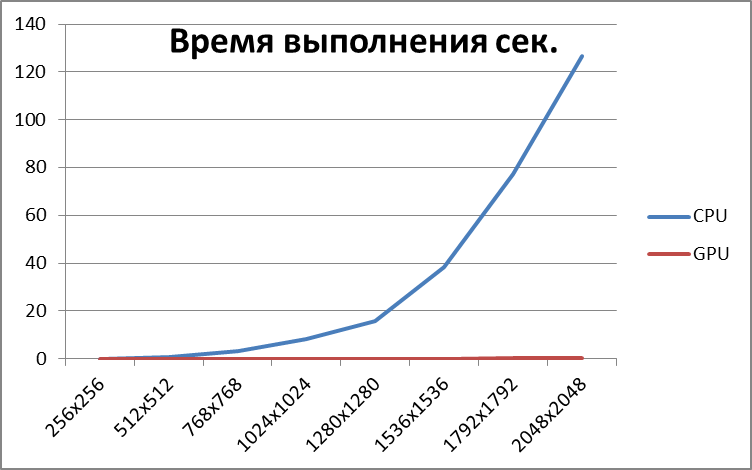

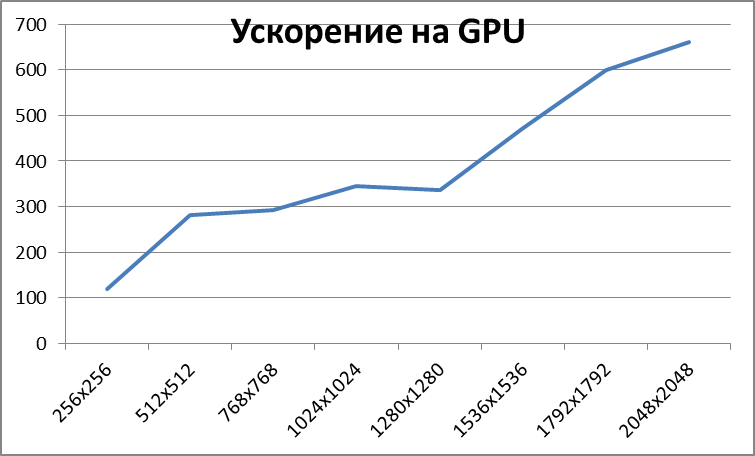